# Exercise 5

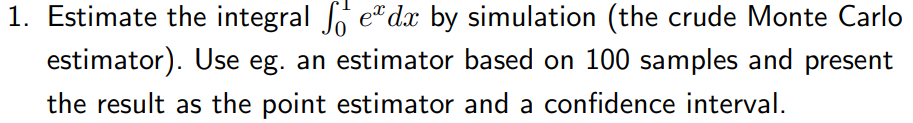

In order to estimate the following integral:
$$
\int_{1}^{0} e^x dx
$$
we use the crude Monte-Carlo estimator by simulation.

First, we let $U_1,\dots,U_n\sim\text{Uniform}(0,1)$. Then, we can write:
$$
\int_{1}^{0} e^x dx = \text{E}[e^U]
$$

This we can use to simulate $n=100$ samples of $U$ and thus, compute the point estimator $\hat{\theta}$:
$$
\hat{\theta} = \frac{1}{n}\sum_{i=1}^n e^{U_i}
$$


In [45]:
import numpy as np
import scipy.stats as stats

n = 100
u = np.random.uniform(0, 1, n)
values = np.exp(u)
estimator = np.mean(values)
std_dev = np.std(values, ddof=1)
se = std_dev / np.sqrt(n)
z = stats.norm.ppf(0.975)
lower = estimator - z * se
upper = estimator + z * se
print(f"Point estimator for the integral: {estimator:.3f}")
print(f"95% confidence interval: ({lower:.2f}, {upper:.2f})")

Point estimator for the integral: 1.654
95% confidence interval: (1.56, 1.75)


Thus, we can observe the Monte-Carlo estimate of the integral of 100 samples, while we are 95% confident in the true number lying between the confidence interval.

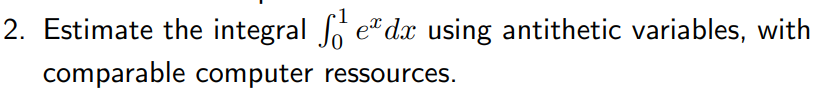

To estimate 
$$
\int_{1}^{0} e^x dx
$$

using antithetic variables, we will utilize the variance reduction technique. Herein, we average each function $e^U$ with its antithetic pair $e^{1-U}$, aiming to cancel out any variation:

In [46]:
values = (np.exp(u) + np.exp(1 - u)) / 2
estimator = np.mean(values)
std_dev = np.std(values, ddof=1)
se = std_dev / np.sqrt(n)
lower = estimator - z * se
upper = estimator + z * se

print(f"Point estimator for the integral: {estimator:.3f}")
print(f"95% confidence interval: ({lower:.3f}, {upper:.3f})")

Point estimator for the integral: 1.712
95% confidence interval: (1.698, 1.725)


No matter the 100 Uniform values generated in $u$, this estimate is always closer to the true value, which is $1-e\approx1.718$. The confidence interval is also narrower than with the crude method, showing the antithetic method is more confident.

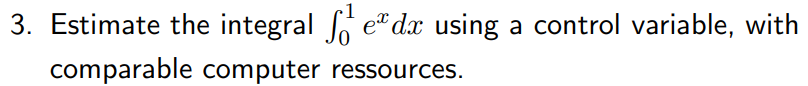

Estimating the integral using a control variate, we use $U\sim\text{Uniform}(0,1)$ as the control variate. We apply the corrected estimator:
$$
\hat{\theta}_{cv} = \bar{X}+c(Y-\text{E}[Y])
$$
where $c$ is chosen as to minimize the variance:


In [47]:
x = np.exp(u)
y = u 

cov_xy = np.cov(x, y, ddof=1)[0, 1]
var_y = np.var(y, ddof=1)
c = -cov_xy / var_y

controlled = x + c * (y - 0.5)
estimator = np.mean(controlled)

std_dev = np.std(controlled, ddof=1)
se = std_dev / np.sqrt(n)
lower = estimator - z * se
upper = estimator + z * se

print(f"Point estimator for the integral: {estimator:.3f}")
print(f"95% confidence interval: ({lower:.3f}, {upper:.3f})")

Point estimator for the integral: 1.712
95% confidence interval: (1.699, 1.725)


Again, this is close to the true value of $1-e\approx1.718$

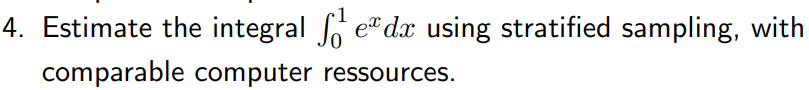

Using the stratified sampling method, we split the interval [0,1] into 100 equal-width subintervals. Here, in each subinterval $[\frac{i-1}{100}, \frac{i}{100}]$, one sample is drawn, ensuring even coverage, and reducing variance.

In [48]:
u = (np.random.uniform(0, 1, n) + np.arange(n)) / n  
values = np.exp(u)

estimator = np.mean(values)
std_dev = np.std(values, ddof=1)
se = std_dev / np.sqrt(n)
lower = estimator - z * se
upper = estimator + z * se

print(f"Point estimator for the integral: {estimator:.3f}")
print(f"95% confidence interval: ({lower:.3f}, {upper:.3f})")

Point estimator for the integral: 1.718
95% confidence interval: (1.621, 1.815)


The estimate is close to the true value of $1-e\approx1.718$, but it has a wider confidence interval. That means the method did perform worse.

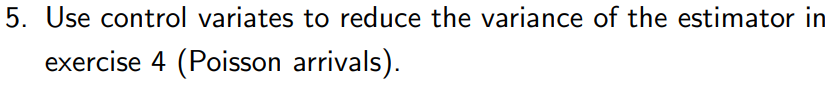

To further reduce the variance by using the control variates, we combine stratified sampling and control variate methods. Specifically, we seek the the corrected estimator $\hat{\theta}_{cv}$:
$$
\hat{\theta}_{cv} = \bar{X}+c(Y-\text{E}[Y])
$$
while using stratified values:

In [49]:
u = (np.random.uniform(0, 1, n) + np.arange(n)) / n  
x = np.exp(u)
y = u 

cov_xy = np.cov(x, y, ddof=1)[0, 1]
var_y = np.var(y, ddof=1)
c = -cov_xy / var_y

adjusted = x + c * (y - 0.5)
estimator = np.mean(adjusted)

std_dev = np.std(adjusted, ddof=1)
se = std_dev / np.sqrt(n)
z = stats.norm.ppf(0.975)
lower = estimator - z * se
upper = estimator + z * se

print(f"Point estimator for the integral: {estimator:.3f}")
print(f"95% confidence interval: ({lower:.3f}, {upper:.3f})")

Point estimator for the integral: 1.718
95% confidence interval: (1.706, 1.731)


This method has proven the best so far for optaining both the best estimate and also the narrowest confidence interval.

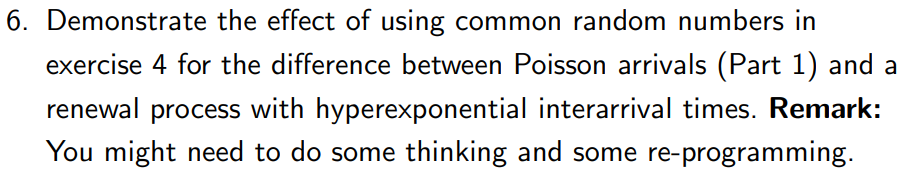

Now, we will return to exercise 4.1 and take some of the code as for inspiration.

We have set up the same system, but we compare the blocking abilities two systems: one with Poisson arrivals and one with hyperexponential interarrival times. Now, we will reimplement them but with Common Random Numbers (CRNs), hopefully reducing the variance of the difference between the systems:

In [66]:
from scipy.stats import norm
import heapq

np.random.seed(1234)
m = 10
mean_service = 8
service_rate = 1 / mean_service
num_batches = 10
customers_per_batch = 10000
alpha = 0.05
lambda_poisson = 1

p1 = 0.8
lambda1 = 0.8333
lambda2 = 5.0

z = norm.ppf(1 - alpha / 2)

def simulate_blocking_system(arrival_times, service_times, m):
    server_end_times = []
    blocked = 0
    current_time = 0.0

    for i in range(len(arrival_times)):
        current_time += arrival_times[i]
        service_time = service_times[i]
        server_end_times = [t for t in server_end_times if t > current_time]
        if len(server_end_times) < m:
            heapq.heappush(server_end_times, current_time + service_time)
        else:
            blocked += 1

    return blocked / len(arrival_times)

diffs_crn = []
diffs_indep = []

for _ in range(num_batches):
    u_interarrival = np.random.uniform(0, 1, customers_per_batch)
    u_phase = np.random.uniform(0, 1, customers_per_batch)
    u_service = np.random.uniform(0, 1, customers_per_batch)

    service_times = -np.log(u_service) / service_rate

    poisson_arrivals = -np.log(u_interarrival) / lambda_poisson
    hyper_arrivals = np.where(
        u_phase < p1,
        -np.log(u_interarrival) / lambda1,
        -np.log(u_interarrival) / lambda2
    )

    bp_poisson_crn = simulate_blocking_system(poisson_arrivals, service_times, m)
    bp_hyper_crn = simulate_blocking_system(hyper_arrivals, service_times, m)
    diffs_crn.append(bp_poisson_crn - bp_hyper_crn)

    u_inter_poi = np.random.uniform(0, 1, customers_per_batch)
    u_serv_poi = np.random.uniform(0, 1, customers_per_batch)
    u_inter_hyp = np.random.uniform(0, 1, customers_per_batch)
    u_phase_hyp = np.random.uniform(0, 1, customers_per_batch)
    u_serv_hyp = np.random.uniform(0, 1, customers_per_batch)

    service_poi = -np.log(u_serv_poi) / service_rate
    service_hyp = -np.log(u_serv_hyp) / service_rate

    inter_poi = -np.log(u_inter_poi) / lambda_poisson
    inter_hyp = np.where(
        u_phase_hyp < p1,
        -np.log(u_inter_hyp) / lambda1,
        -np.log(u_inter_hyp) / lambda2
    )

    bp_poi_indep = simulate_blocking_system(inter_poi, service_poi, m)
    bp_hyp_indep = simulate_blocking_system(inter_hyp, service_hyp, m)
    diffs_indep.append(bp_poi_indep - bp_hyp_indep)

mean_crn = np.mean(diffs_crn)
var_crn = np.var(diffs_crn, ddof=1)
mean_indep = np.mean(diffs_indep)
var_indep = np.var(diffs_indep, ddof=1)

print(f"With CRN:    Mean diff = {mean_crn:.5f}, Variance = {var_crn:.7f}")
print(f"Without CRN: Mean diff = {mean_indep:.5f}, Variance = {var_indep:.7f}")

With CRN:    Mean diff = -0.01749, Variance = 0.0000144
Without CRN: Mean diff = -0.02032, Variance = 0.0001154


These results shows that the mean difference in the blocking probability between the Poissson and Hyperexponential-distributed interarrival times is about -0.017 in both cases, indicating the hyperexponential system block on average 1.7% fewer customers than the Poisson-distributed does. This proves that implementing CRN made the comparison between the two systems much more precise without increasing the number of simulations and computations.

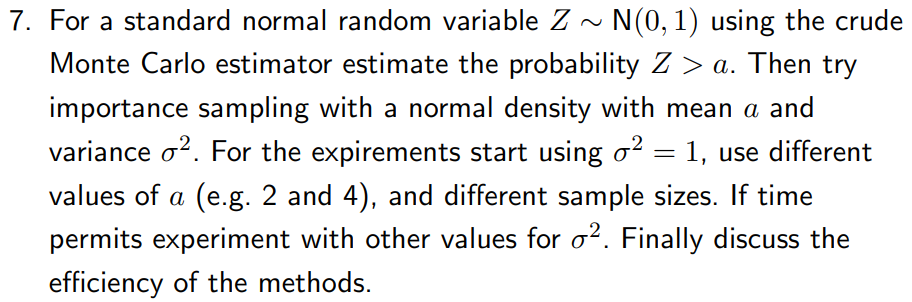

To estimate $\text{P}(Z>a)$ for $Z\sim \text{N}(0,1)$ using the crude Monte-Carlo and importance sampling methods. For importance sampling, we use a $\text{N}(0,1)$ and apply a likelihood ratio weighting. The experiments are done for the values $a\in\{2,4\}$, $n\in\{1000,10000\}$, and $\sigma^2=1$, to compare the accuracies and variances:

In [57]:
a_values = [2, 4]
sample_sizes = [1000, 10000]
sigma = 1  
results = []

for a in a_values:
    for n in sample_sizes:
        z = np.random.normal(0, 1, n)
        crude_estimates = (z > a).astype(float)
        crude_prob = float(np.mean(crude_estimates))
        crude_var = float(np.var(crude_estimates, ddof=1))

        x = np.random.normal(a, np.sqrt(sigma), n)
        weights = norm.pdf(x, 0, 1) / norm.pdf(x, a, np.sqrt(sigma))
        is_estimates = weights * (x > a)
        is_prob = float(np.mean(is_estimates))
        is_var = float(np.var(is_estimates, ddof=1))

        results.append({
            "a": a,
            "n": n,
            "crude_prob": round(crude_prob, 6),
            "crude_var": round(crude_var, 6),
            "is_prob": round(is_prob, 6),
            "is_var": round(is_var, 6)
        })

results

[{'a': 2,
  'n': 1000,
  'crude_prob': 0.026,
  'crude_var': 0.025349,
  'is_prob': 0.021139,
  'is_var': 0.001157},
 {'a': 2,
  'n': 10000,
  'crude_prob': 0.0216,
  'crude_var': 0.021136,
  'is_prob': 0.0225,
  'is_var': 0.001189},
 {'a': 4,
  'n': 1000,
  'crude_prob': 0.0,
  'crude_var': 0.0,
  'is_prob': 3.2e-05,
  'is_var': 0.0},
 {'a': 4,
  'n': 10000,
  'crude_prob': 0.0,
  'crude_var': 0.0,
  'is_prob': 3.1e-05,
  'is_var': 0.0}]

From this, we can conclude the following:

- For $a=2$, both the crude Monte-Carlo and importance sampling produce reasonable estimates, but importance sampling has lower variance, making it more efficient.
- For $a=4$, crude Monte Carlo fails  (probability = 0), while importance sampling still gives a valid, low-variance estimate.

This demonstrates that importance sampling is especially valuable for rare event estimation, wherein crude Monte Carlo becomes unreliable.

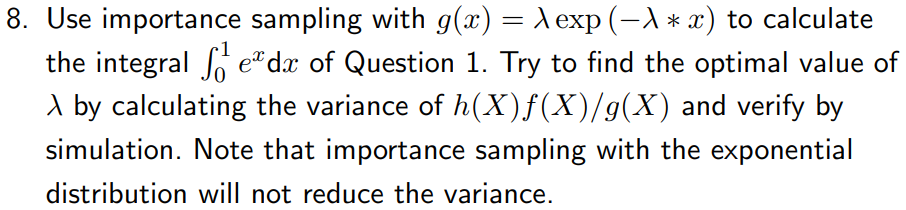

To estimate the integral of Question 1, we use importance sampling, by sampling from the following exponential distribution:
$$
g(x) = \lambda e ^{\lambda x}, \quad x\in[0,1]
$$

In order to find the optimal value for $\lambda$, we calculate the variance of $\frac{h(X)\cdot f(X)}{g(X)}$ and verify it by simulation. We simulate $n=10000$ runs.


In [65]:
from scipy.stats import expon

n = 10000
lambdas = np.linspace(0.1, 5, 50)
variances = []

for lam in lambdas:
    samples = np.random.exponential(1 / lam, n)
    mask = samples <= 1
    x = samples[mask]
    
    if len(x) == 0:
        variances.append(np.nan)
        continue
    
    h = np.exp(x)
    f = np.ones_like(x)  
    g = lam * np.exp(-lam * x)  
    
    weights = h * f / g
    variances.append(np.var(weights, ddof=1))

optimal_index = np.nanargmin(variances)
optimal_lambda = lambdas[optimal_index]
min_variance = variances[optimal_index]

print("Optimal lambda:", round(float(optimal_lambda), 2))
print("Minimum variance:", round(float(min_variance), 4))

Optimal lambda: 1.0
Minimum variance: 2.5918


Here, the optimal $\lambda$ is 1, with a corresponding variance of approximately 2.5918.

Thus, using exponential sampling does not reduce the variance, and is not an efficient choice for this particular integral.

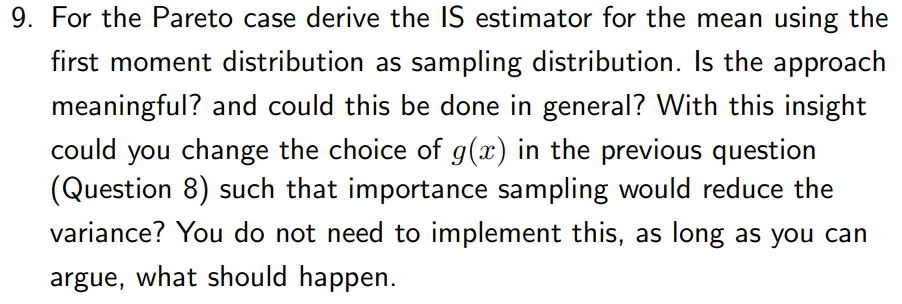